In [1]:
#ライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import os
import argparse

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.utils as vutils
import torchvision.transforms as transforms

#data配下にMNISTのデータがダウンロードされる。
dataset=dset.MNIST("./data/",train=True,download=True)

/home/yusuke/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#ハイパーパラメータを設定
#parserを初期化
parser=argparse.ArgumentParser()

#parserに引数を設定していく
#エポック数の設定
parser.add_argument("--n_epoch",type=int,default=200)
#バッチサイズ
parser.add_argument("--batch_size",type=int,default=64)
#学習率
parser.add_argument("--lr",type=float,default=2e-4)
#生成器のチャネル数
parser.add_argument("--nch_g",type=int,default=128)
#識別器のチャネル数
parser.add_argument("--nch_d",type=int,default=128)
#ノイズの次元
parser.add_argument("--z_dim",type=int,default=100)
#Adam Optimizerのパラメータ
parser.add_argument("--beta1",type=float,default=0.5)

#optに作成したハイパーパラメータの組を渡す。(デフォルトで入れている値そのまま)
opt=parser.parse_args(args=[])

In [3]:
# 生成器のクラスを定義(nn.Moduleクラスを継承)

class Generator(nn.Module):
    def __init__(self,z_dim=100,ngf=128,nc=1):
        super().__init__()
        #図の立方体一つがconvtXとなる。
        self.convt1=self.conv_trans_layers(z_dim,4*ngf,3,1,0)
        self.convt2=self.conv_trans_layers(4*ngf,2*ngf,3,2,0)
        self.convt3=self.conv_trans_layers(2*ngf,ngf,4,2,1)
        #図の最後の立方体のみ構造が異なるので個別に作成
        self.convt4=nn.Sequential(
            nn.ConvTranspose2d(ngf,nc,4,2,1),
            nn.Tanh()
        )
    
    #図の立方体のネットワークつまり、転置畳み込み + Batch Norm + Reluの構造を作成
    @staticmethod 
    def conv_trans_layers(in_channels,out_channels,kernel_size,stride,padding):
        net=nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return net
    
    #フォワード計算
    def forward(self,x):
        #1層目にインプットを与え、出力されたアウトプットを2層目のインプットにする。ということを4層目まで行う。
        out=self.convt1(x)
        out=self.convt2(out)
        out=self.convt3(out)
        out=self.convt4(out)
        return out

In [4]:
# 識別器のクラスを定義(nn.Moduleクラスを継承)
class Discriminator(nn.Module):
    def __init__(self,nc=1,ndf=128):
        super().__init__()
        #1層目は batch_normなし
        self.conv1=self.conv_layers(nc,ndf,has_batch_norm=False)
        #2,3層目は batch_normあり
        self.conv2=self.conv_layers(ndf,2*ndf)
        self.conv3=self.conv_layers(2*ndf,4*ndf,3,2,0)
        #4層目はconvを行ったのちにsigmoid関数を挟む
        self.conv4=nn.Sequential(
            nn.Conv2d(4*ndf,1,3,1,0),
            nn.Sigmoid()
        )
        
    #図の立方体のネットワークつまり、畳み込み + Batch Norm + LeakyReluの構造を作成
    @staticmethod
    def conv_layers(in_channels,out_channels,kernel_size=4,stride=2,padding=1,has_batch_norm=True):
        layers=[
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)
        ]
        #batch_norm層ありを作る場合
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        
        layers.append(nn.LeakyReLU(0.2,inplace=True))
        #生成器の時は直接書いていたが、リストをあらかじめ作成しておき後からSequentialに渡すこともできる。
        net=nn.Sequential(*layers)
        return net
    #フォワード計算    
    def forward(self,x):
        #1層目にインプットを与え、出力されたアウトプットを2層目のインプットにする。ということを4層目まで行う。
        out=self.conv1(x)
        out=self.conv2(out)
        out=self.conv3(out)
        out=self.conv4(out)
        return out

In [5]:
#層の初期化関数定義
def weight_init(m):
    #クラス名(何の層なのか)を取得
    classname=m.__class__.__name__
    #畳み込み層の場合
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data,0,0.02)
    #BatchNorm層の場合
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data,1,0.02)
        nn.init.constant_(m.bias.data,0)
        
#変換の定義
#テンソル配列への変換、正則化を行う
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [6]:
#作成画像、パラメータの保存先を指定
dir_path_1="./result"
dir_path_2="./params"
#ディレクトリがない場合は作成する
os.makedirs(dir_path_1,exist_ok=True)
os.makedirs(dir_path_2,exist_ok=True)

#パラメータ保存用の関数を定義
def save_params(file_path,epoch,netD,netG):
    torch.save(
        netG.state_dict(),
        file_path+"g_{:04d}.pth".format(epoch)
    )
    torch.save(
        netD.state_dict(),
        file_path+"d_{:04d}.pth".format(epoch)
    )

#データローダにデータを渡す
dataset=dset.MNIST(root="./data/",download=False,train=True,transform=transform)
dataloader=DataLoader(dataset=dataset,batch_size=opt.batch_size,shuffle=True)

#デバイスの設定
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
#生成器作成
netG=Generator(z_dim=opt.z_dim,ngf=opt.nch_g).to(device)
#層の初期化
netG.apply(weight_init)

print(netG)

#識別器作成
netD=Discriminator(nc=1,ndf=opt.nch_d).to(device)
#層の初期化
netD.apply(weight_init)

print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convt4): Sequential(
    (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Tanh()
  )
)
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=

In [8]:
#損失関数(BinaryCrossEntropy)
criterion=nn.BCELoss()

#生成器のOptimizer(Adam)を定義
optimizerG=optim.Adam(netG.parameters(),lr=opt.lr,betas=(opt.beta1,0.999),weight_decay=1e-5)
#識別器のOptimizer(Adam)を定義
optimizerD=optim.Adam(netD.parameters(),lr=opt.lr,betas=(opt.beta1,0.999),weight_decay=1e-5)

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 1, lossD: 0.4694850448447504, lossG: 3.289995639658432


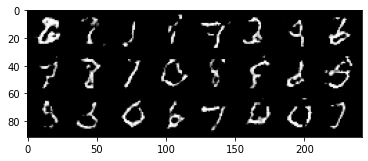

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.53it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 2, lossD: 0.600069081716573, lossG: 2.4006499312142893


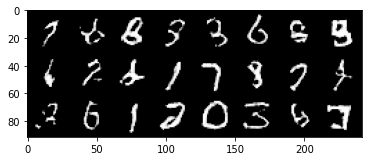

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 3, lossD: 0.5954251418998247, lossG: 2.4533501692227464


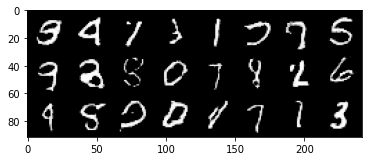

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.47it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 4, lossD: 0.6491942798722782, lossG: 2.3844600936878466


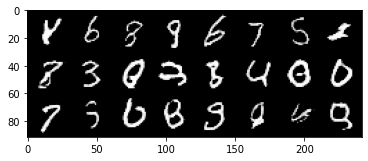

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 5, lossD: 0.6063942391989328, lossG: 2.513840026573649


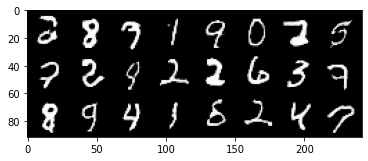

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 6, lossD: 0.612400221767456, lossG: 2.5166392162092714


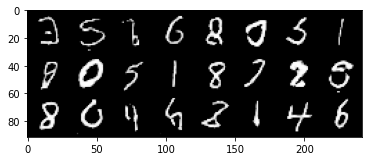

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.31it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 7, lossD: 0.6024559858098213, lossG: 2.5654820752804723


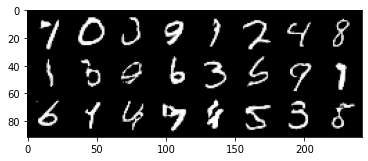

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.32it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 8, lossD: 0.5725550449320248, lossG: 2.6748611507004005


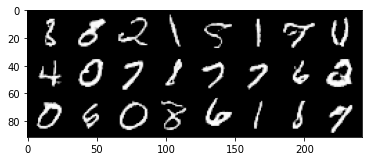

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 30.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 9, lossD: 0.5442963733252432, lossG: 2.773097944888733


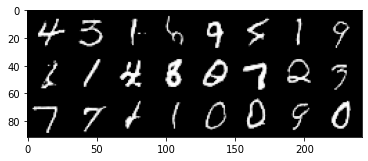

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 30.11it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 10, lossD: 0.5206186754394696, lossG: 2.8538230724775713


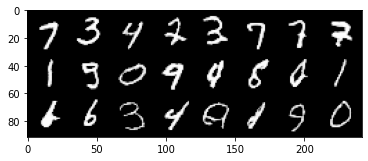

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 30.11it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 11, lossD: 0.5189839919397572, lossG: 2.9048617726990154


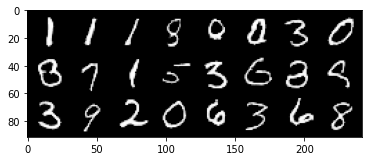

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 30.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 12, lossD: 0.48003754928422127, lossG: 3.0040004503116933


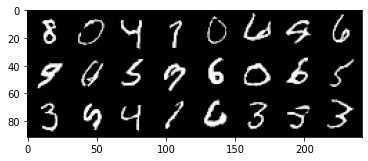

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 30.06it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 13, lossD: 0.4867798494997182, lossG: 3.0465527113630317


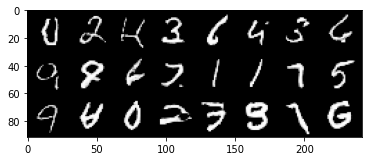

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 30.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 14, lossD: 0.4547063471920201, lossG: 3.128875645874406


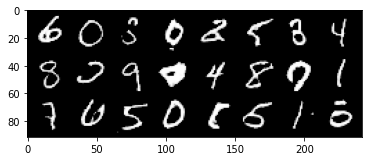

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 30.25it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 15, lossD: 0.48525256364107894, lossG: 3.113936255926262


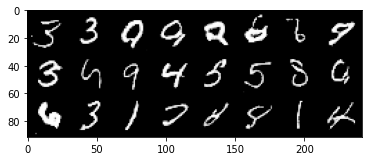

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 29.81it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 16, lossD: 0.44990449421790873, lossG: 3.2082288625525006


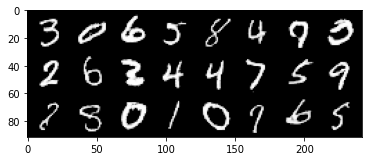

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:32<00:00, 29.02it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 17, lossD: 0.4482100664663798, lossG: 3.214395979280347


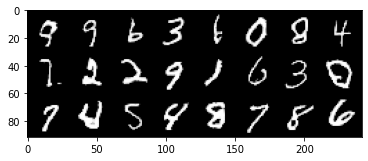

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 29.55it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 18, lossD: 0.45058317827199823, lossG: 3.314584586062411


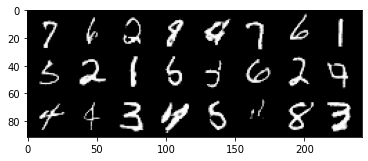

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:32<00:00, 29.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 19, lossD: 0.43888607727629797, lossG: 3.309097063026703


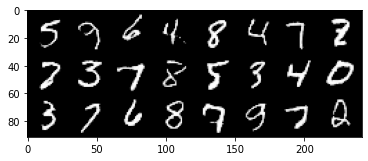

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:32<00:00, 28.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 20, lossD: 0.404577037085221, lossG: 3.4098475720169446


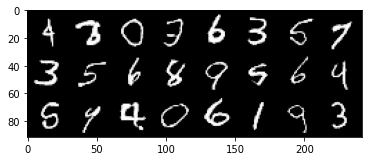

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:32<00:00, 29.26it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 21, lossD: 0.42793722115536487, lossG: 3.4022544467372935


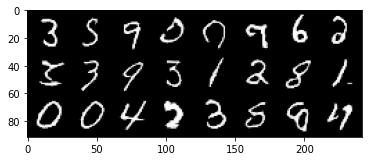

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:32<00:00, 29.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 22, lossD: 0.4049064768339271, lossG: 3.4690465363326357


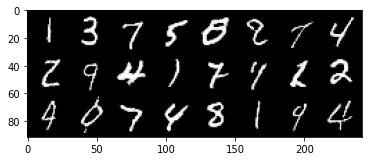

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:32<00:00, 28.84it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 23, lossD: 0.3945049208714001, lossG: 3.518472098401869


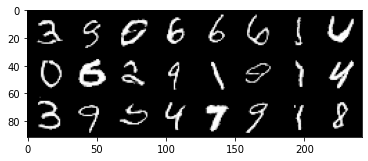

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:32<00:00, 28.75it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 24, lossD: 0.40367546040556834, lossG: 3.5499985096181854


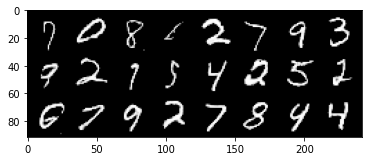

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 29.54it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 25, lossD: 0.3840431159636232, lossG: 3.6292781842542863


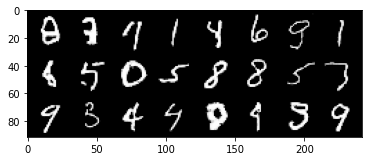

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.47it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 26, lossD: 0.3755334477816055, lossG: 3.6148691705422107


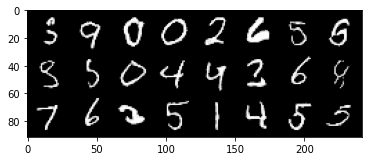

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 27, lossD: 0.395570871751827, lossG: 3.641450614598927


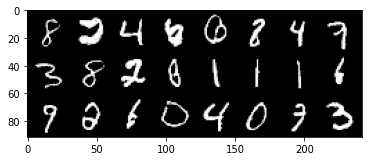

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 28, lossD: 0.3386727698496791, lossG: 3.759469343941095


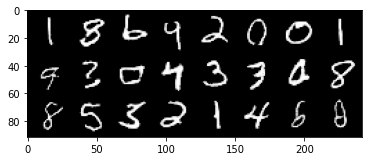

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 29, lossD: 0.40591642614017165, lossG: 3.6569427474062324


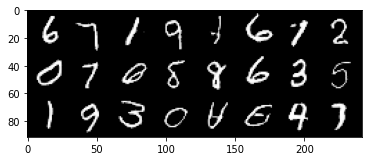

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 30, lossD: 0.38264845348974025, lossG: 3.675231809197649


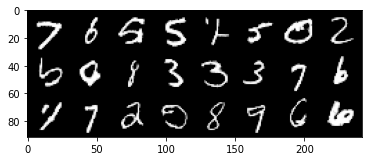

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.59it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 31, lossD: 0.3433872842903076, lossG: 3.7726652343262996


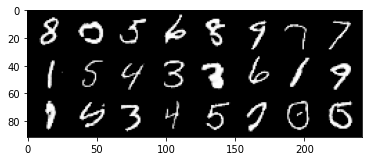

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 32, lossD: 0.36480494529834945, lossG: 3.7633636060363447


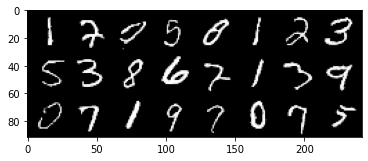

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.47it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 33, lossD: 0.36863405456834003, lossG: 3.8045592912828234


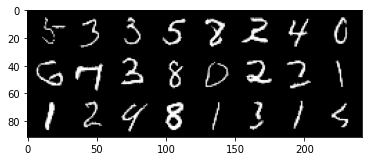

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.41it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 34, lossD: 0.35742074126866197, lossG: 3.809648539537369


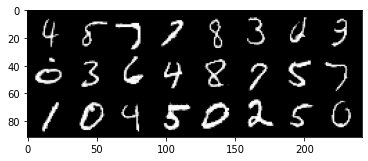

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.34it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 35, lossD: 0.3352925204105977, lossG: 3.8641161808072884


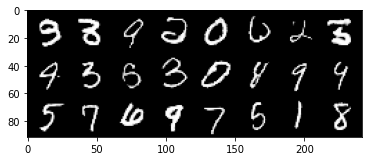

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 36, lossD: 0.37086609905081264, lossG: 3.89221540231631


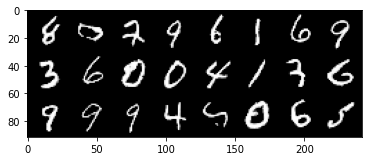

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.55it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 37, lossD: 0.3594966151836966, lossG: 3.844256364158603


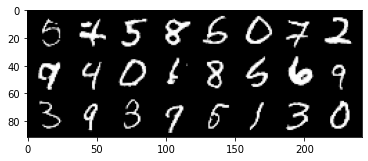

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.71it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 38, lossD: 0.3369130130642767, lossG: 3.9673620869697475


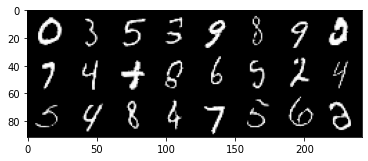

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 39, lossD: 0.3212698442913068, lossG: 3.9852819539495368


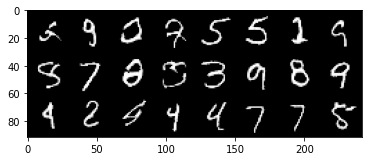

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 30.21it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 40, lossD: 0.3426423764614853, lossG: 3.975388881875508


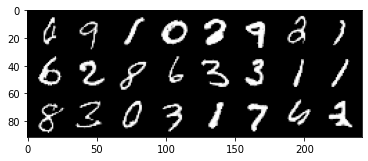

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.50it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 41, lossD: 0.31482727412205896, lossG: 4.027670006682751


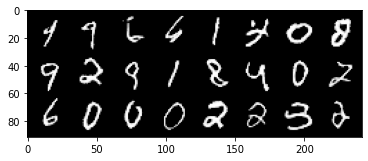

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 42, lossD: 0.3703889181333056, lossG: 4.008667076576446


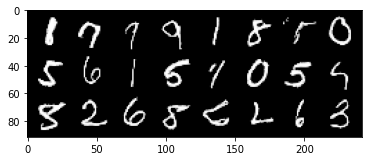

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.34it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 43, lossD: 0.31629991677524183, lossG: 4.014755497005448


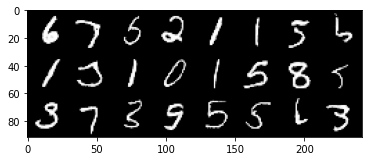

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 44, lossD: 0.3016692812064055, lossG: 4.126737061149276


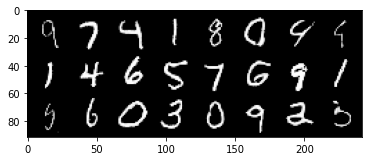

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 45, lossD: 0.3081773747004934, lossG: 4.10764692304358


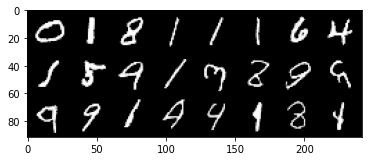

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.72it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 46, lossD: 0.3343428167691236, lossG: 4.1578847719694


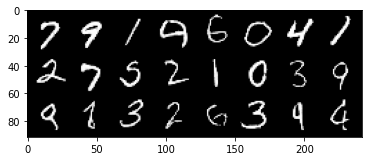

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.44it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 47, lossD: 0.32486939616104177, lossG: 4.136964512405111


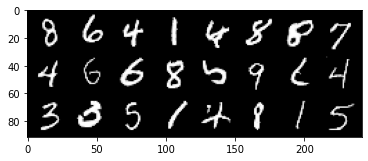

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.48it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 48, lossD: 0.2815342314029013, lossG: 4.248095794844983


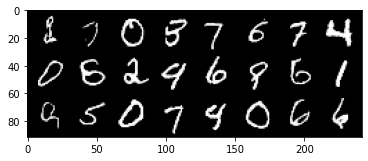

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.54it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 49, lossD: 0.3249232526173565, lossG: 4.2416440260562815


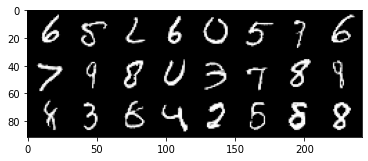

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.52it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 50, lossD: 0.2725221090344414, lossG: 4.275310100395797


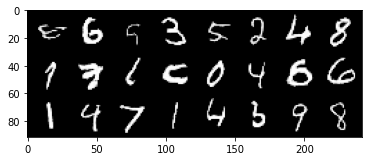

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 51, lossD: 0.30493730848341355, lossG: 4.275141484892445


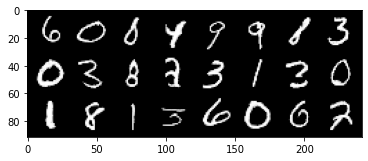

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 52, lossD: 0.2815147339860831, lossG: 4.362126832132909


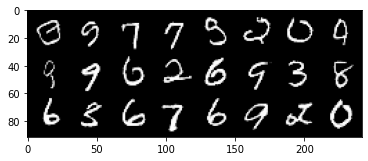

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 53, lossD: 0.29896032498247904, lossG: 4.326196916703222


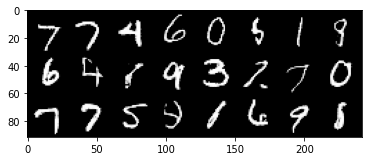

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 54, lossD: 0.3136632269653462, lossG: 4.299633951664695


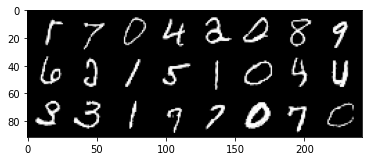

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 55, lossD: 0.26819270407197193, lossG: 4.437633223085007


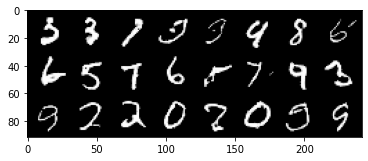

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.47it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 56, lossD: 0.2916476129611799, lossG: 4.3356421664516045


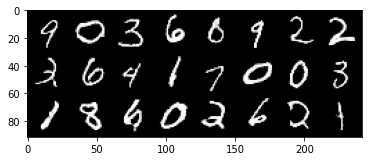

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.64it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 57, lossD: 0.30716304037410186, lossG: 4.37152215892445


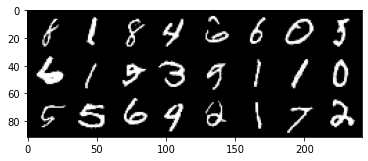

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.44it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 58, lossD: 0.25621499768944817, lossG: 4.526842629592092


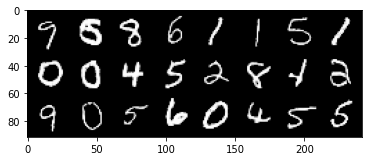

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 59, lossD: 0.3003565009210759, lossG: 4.451096156804658


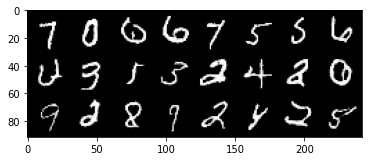

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 60, lossD: 0.2675993945529021, lossG: 4.462558757140438


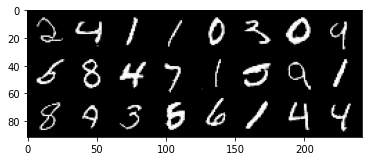

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 61, lossD: 0.2536166889914699, lossG: 4.544731917125838


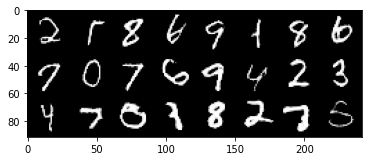

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 62, lossD: 0.2685866089744259, lossG: 4.567550608153536


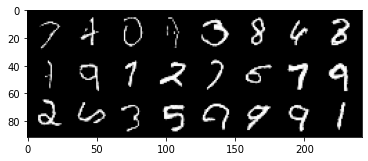

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 63, lossD: 0.2698612774092791, lossG: 4.547166405376722


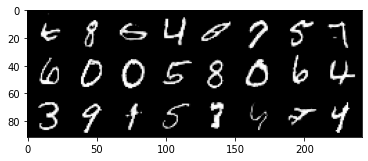

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.48it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 64, lossD: 0.2924889865468369, lossG: 4.489558541793813


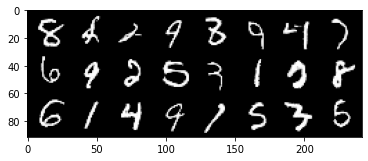

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.52it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 65, lossD: 0.25390003723646404, lossG: 4.499835291873417


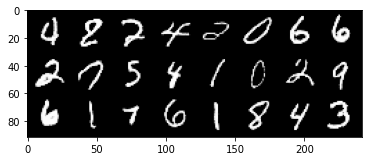

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.42it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 66, lossD: 0.2720905714995984, lossG: 4.580003527435921


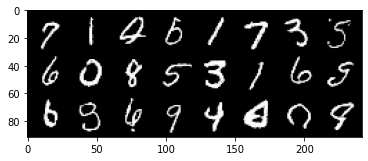

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 67, lossD: 0.24108007003360593, lossG: 4.691658867860654


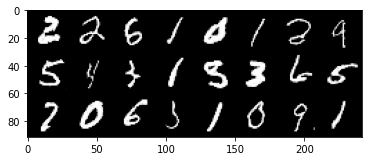

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.48it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 68, lossD: 0.26568744569691194, lossG: 4.685563507428301


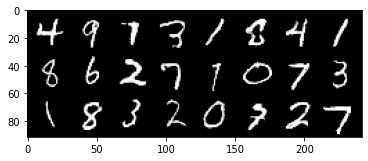

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 69, lossD: 0.2426915316562504, lossG: 4.747851830142648


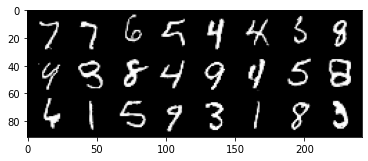

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 70, lossD: 0.24441563042162706, lossG: 4.727378289868582


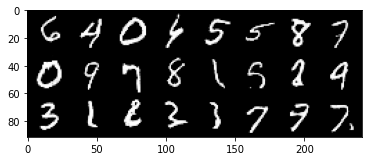

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.42it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 71, lossD: 0.2278625249687924, lossG: 4.697189744696942


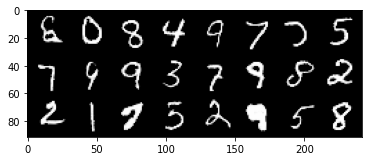

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 72, lossD: 0.26599693538716385, lossG: 4.76056289920079


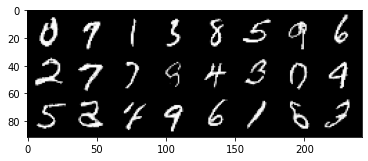

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 73, lossD: 0.2504230371054842, lossG: 4.759753875942754


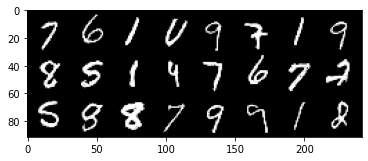

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 74, lossD: 0.20889663014378249, lossG: 4.918439187729028


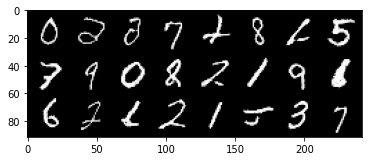

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.37it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 75, lossD: 0.23601997088688587, lossG: 4.789227839900867


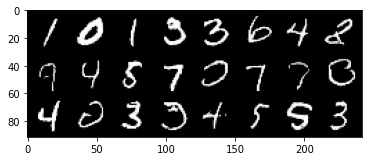

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.52it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 76, lossD: 0.27656491997757, lossG: 4.771912775917857


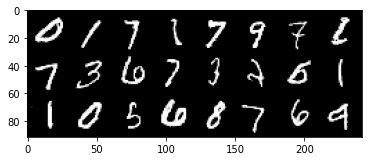

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.73it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 77, lossD: 0.1716428587286632, lossG: 4.976685626166208


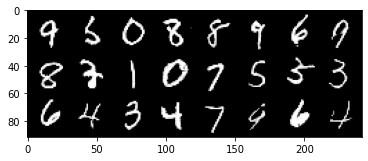

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.56it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 78, lossD: 0.29581338550045544, lossG: 4.771375530138254


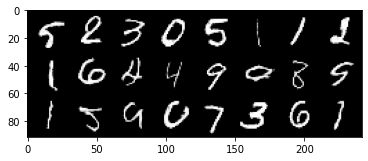

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.50it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 79, lossD: 0.18335558015948483, lossG: 4.980036510460413


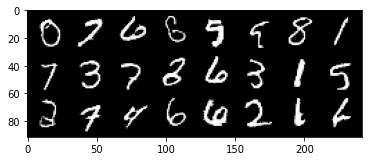

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 80, lossD: 0.25101853911476985, lossG: 4.919312872167335


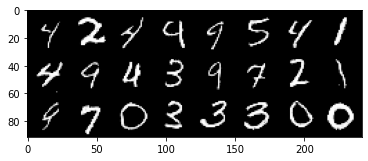

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.52it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 81, lossD: 0.2755758300292562, lossG: 4.963487730415137


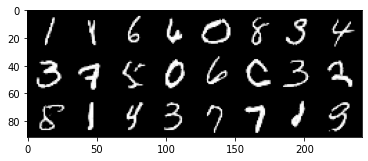

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 82, lossD: 0.18889901103344617, lossG: 4.876575351523947


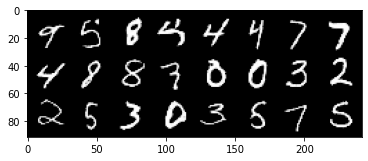

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.48it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 83, lossD: 0.24933018163442294, lossG: 4.866478332019509


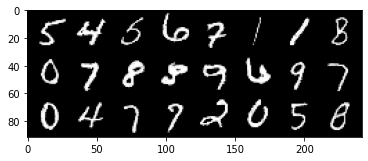

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 84, lossD: 0.2346917176102874, lossG: 5.063527104839968


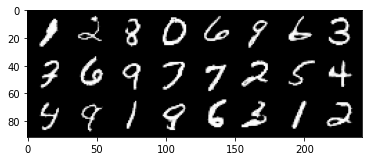

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 85, lossD: 0.2164768130143187, lossG: 4.936440771767326


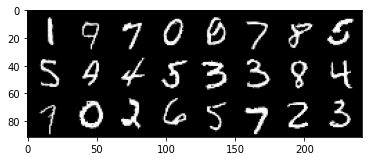

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 86, lossD: 0.17406814585902544, lossG: 5.162562406711233


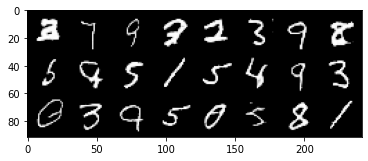

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.34it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 87, lossD: 0.24983760446055867, lossG: 4.996217400633863


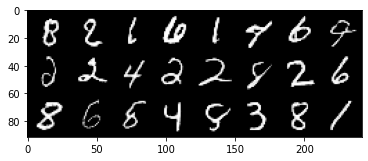

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.52it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 88, lossD: 0.18868005448090497, lossG: 5.119889666785055


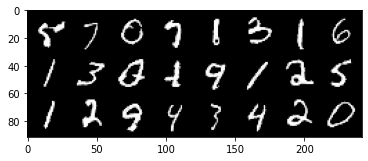

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 89, lossD: 0.24531576942418143, lossG: 5.09831320738265


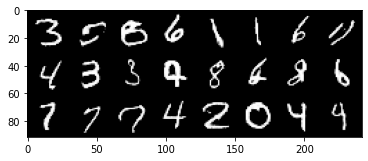

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 90, lossD: 0.20813897690241304, lossG: 5.140589147869712


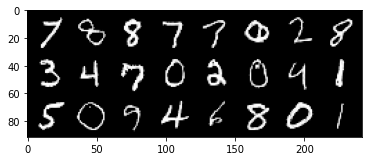

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.41it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 91, lossD: 0.22363306528954172, lossG: 4.992520403982734


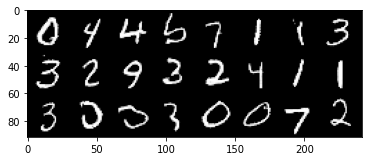

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 92, lossD: 0.23621470916734288, lossG: 5.083135457192824


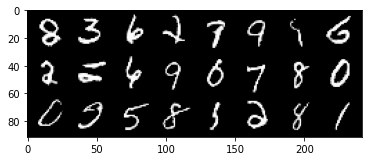

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 93, lossD: 0.20963894448249037, lossG: 5.077352078881726


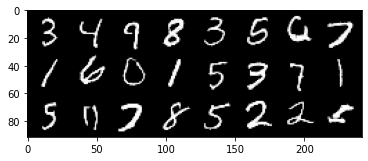

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.42it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 94, lossD: 0.24151596678113108, lossG: 5.148257867898544


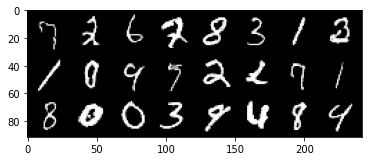

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.41it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 95, lossD: 0.20256289482208045, lossG: 5.1231323402764195


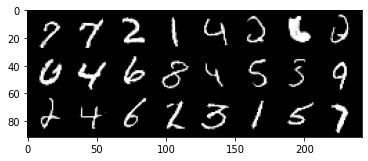

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.50it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 96, lossD: 0.17242870674923316, lossG: 5.199006020069631


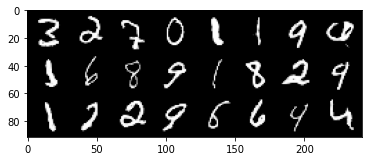

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.42it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 97, lossD: 0.26619338877161525, lossG: 5.193058626837472


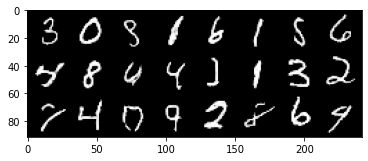

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.47it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 98, lossD: 0.16138897655305387, lossG: 5.285958252926625


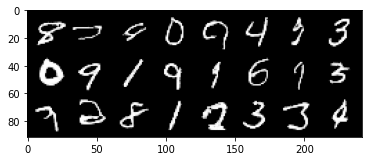

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 99, lossD: 0.1892789292590085, lossG: 5.287033085629884


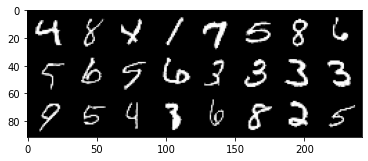

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 100, lossD: 0.19104414134780798, lossG: 5.255470750714416


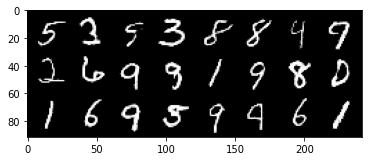

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 101, lossD: 0.16492326014232375, lossG: 5.3298421433167675


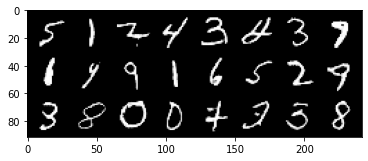

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 102, lossD: 0.25333151232892037, lossG: 5.163249654254552


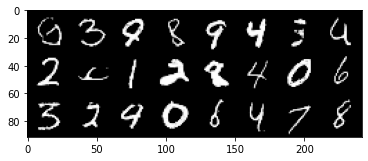

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 103, lossD: 0.1751565359451417, lossG: 5.3451349195609215


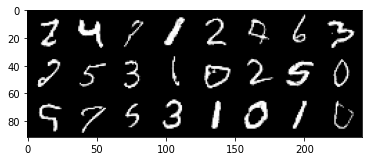

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 104, lossD: 0.17457331930384484, lossG: 5.4630022187794705


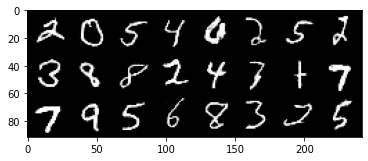

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.30it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 105, lossD: 0.1733961562767053, lossG: 5.484728522074502


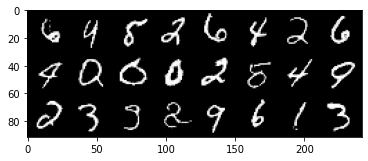

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 106, lossD: 0.2909295238988367, lossG: 5.337325449146681


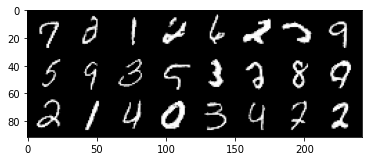

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.50it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 107, lossD: 0.15447197720182063, lossG: 5.404781587707844


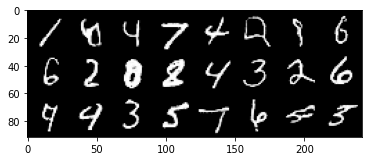

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 108, lossD: 0.16707148706055938, lossG: 5.614615966643352


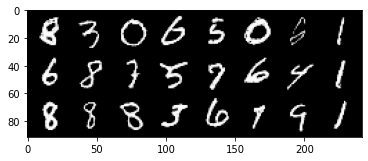

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 109, lossD: 0.17624307050010257, lossG: 5.403402726565089


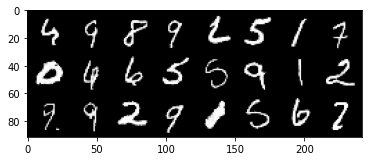

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.35it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 110, lossD: 0.21493618626461258, lossG: 5.4256274330336405


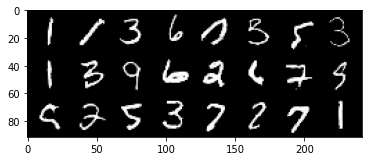

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 111, lossD: 0.17272881090517905, lossG: 5.402973254320464


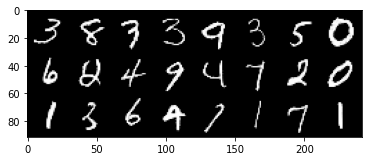

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.49it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 112, lossD: 0.1970171381045244, lossG: 5.559904183120107


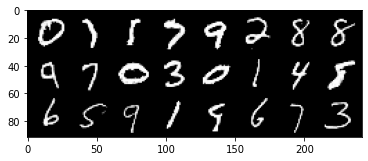

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 113, lossD: 0.2257242064380935, lossG: 5.451838153981363


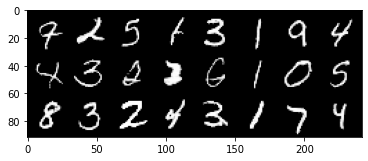

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.44it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 114, lossD: 0.11129076573858733, lossG: 5.541177594839637


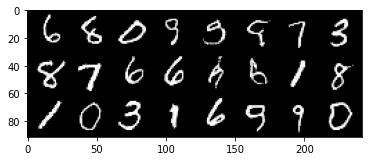

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.57it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 115, lossD: 0.20403679816632161, lossG: 5.483605914548643


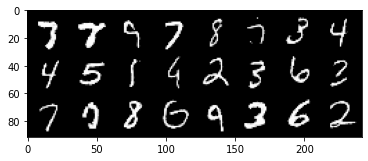

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.66it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 116, lossD: 0.250624868760644, lossG: 5.476766338258155


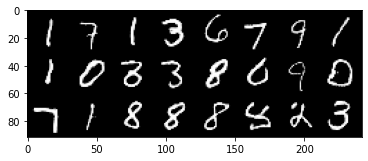

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 117, lossD: 0.15324699091089608, lossG: 5.5907358558955735


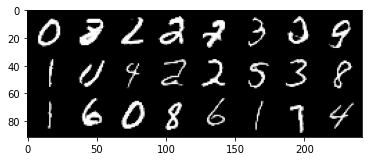

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 118, lossD: 0.1316758951446268, lossG: 5.653070743340673


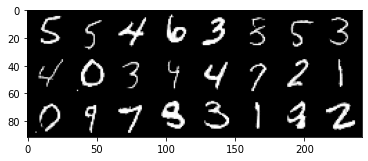

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 119, lossD: 0.1849720018830444, lossG: 5.512555429453789


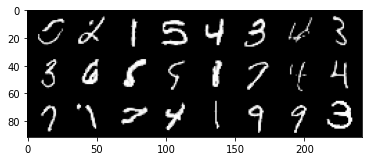

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.34it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 120, lossD: 0.13663379581911222, lossG: 5.716004689365054


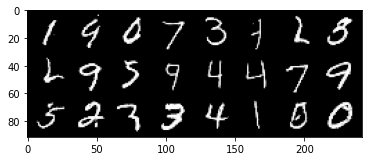

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 121, lossD: 0.19842722000174923, lossG: 5.620712803084968


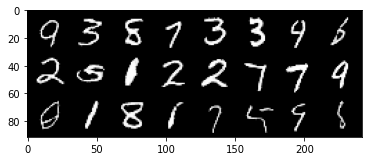

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.41it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 122, lossD: 0.18196522850078592, lossG: 5.871455411285734


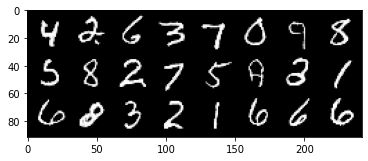

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.49it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 123, lossD: 0.09784713324639938, lossG: 5.712161038603101


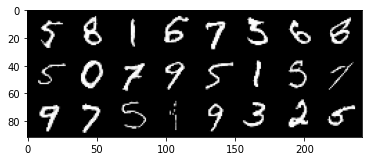

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 124, lossD: 0.20903836076767413, lossG: 5.6760834449453395


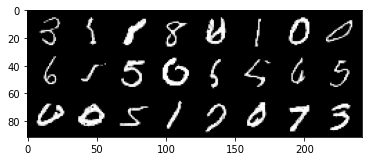

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.48it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 125, lossD: 0.16222741086480777, lossG: 5.599464372346508


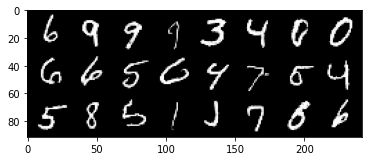

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.50it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 126, lossD: 0.1910702003044948, lossG: 5.668279789777389


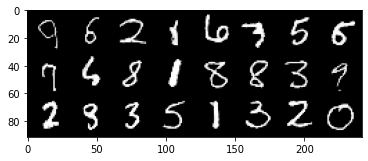

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.57it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 127, lossD: 0.1319064184544739, lossG: 5.824646663103404


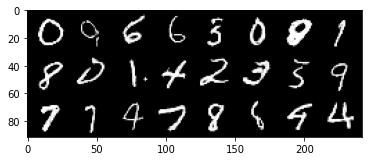

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 128, lossD: 0.18682821196536703, lossG: 5.935396662009741


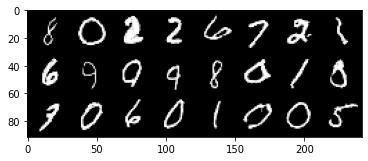

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.40it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 129, lossD: 0.13849630342897717, lossG: 5.6954081646287875


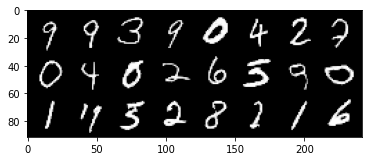

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.47it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 130, lossD: 0.15516790625369195, lossG: 5.807567565108159


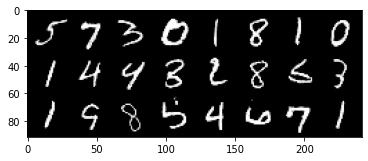

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.61it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 131, lossD: 0.13603335606611408, lossG: 6.049169956779937


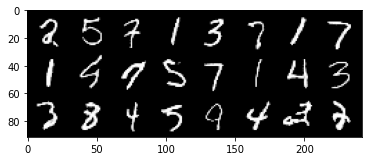

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.57it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 132, lossD: 0.16569786491458302, lossG: 5.848626729220088


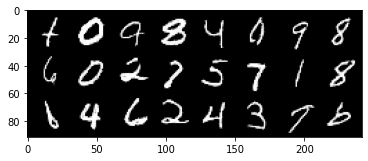

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 29.86it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 133, lossD: 0.10772202292512824, lossG: 5.923104896537785


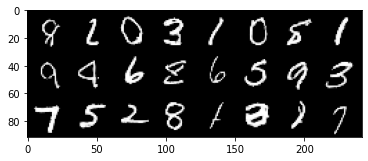

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.32it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 134, lossD: 0.41320382914980497, lossG: 5.510081027203


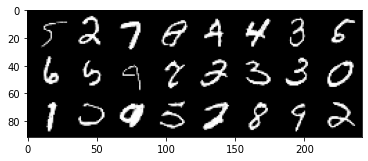

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.42it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 135, lossD: 0.17105292846688996, lossG: 5.953133289708194


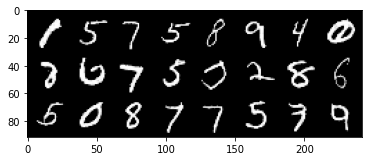

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.31it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 136, lossD: 0.08024602028618712, lossG: 5.995393162724306


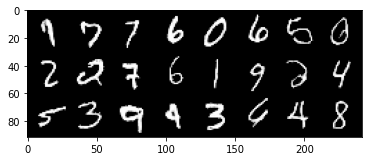

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 137, lossD: 0.18757787069279963, lossG: 5.929155017521335


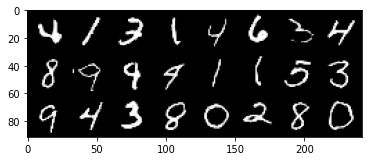

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 138, lossD: 0.14501314240493882, lossG: 6.080887388457844


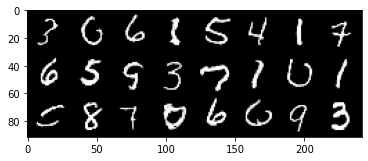

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.61it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 139, lossD: 0.23743868822942793, lossG: 5.839615173137455


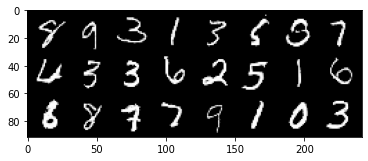

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.55it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 140, lossD: 0.11027233708334137, lossG: 5.718652697768547


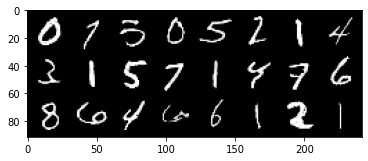

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.42it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 141, lossD: 0.17048370004294, lossG: 5.939012164802058


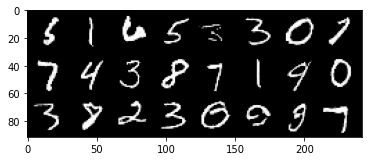

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.50it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 142, lossD: 0.14855607979194219, lossG: 6.002317335210376


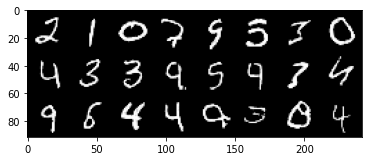

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.44it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 143, lossD: 0.1463832623399258, lossG: 5.957164131474298


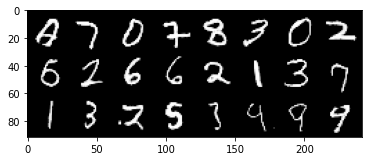

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 144, lossD: 0.12162913673439188, lossG: 6.235164050735644


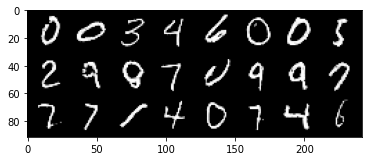

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.48it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 145, lossD: 0.1461640096734713, lossG: 6.0583766567141515


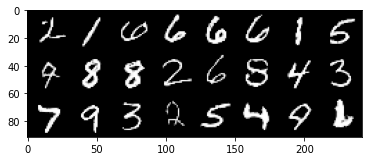

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 146, lossD: 0.08489125970550485, lossG: 6.125538022978219


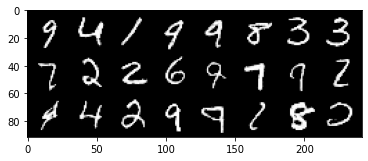

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 147, lossD: 0.1734646286180954, lossG: 5.969737894690113


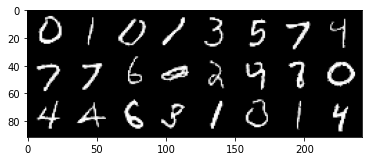

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 148, lossD: 0.10796227034897224, lossG: 6.156848812408285


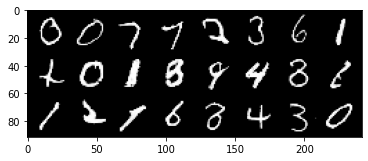

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.34it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 149, lossD: 0.17507391354205137, lossG: 6.010747455997762


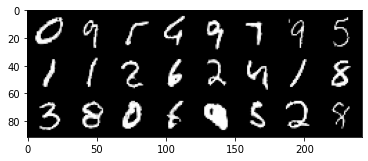

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.53it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 150, lossD: 0.16781325881053677, lossG: 6.165833195929588


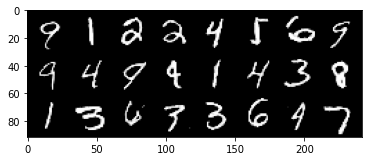

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.35it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 151, lossD: 0.11932467599126345, lossG: 6.1464453110181445


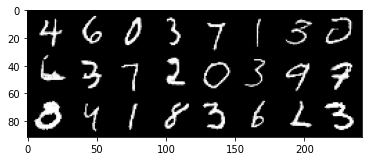

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.27it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 152, lossD: 0.11725837691525208, lossG: 6.10459460210063


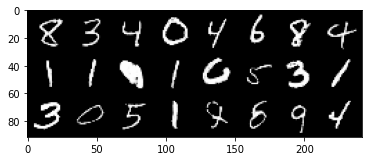

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.40it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 153, lossD: 0.17973058954772872, lossG: 6.095612422378459


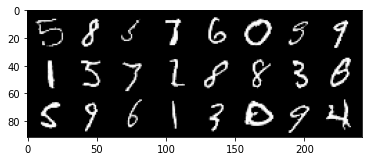

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 154, lossD: 0.1636873984807181, lossG: 6.015845776620958


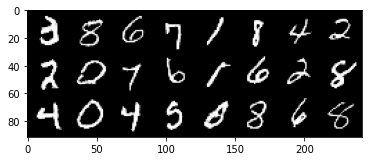

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 155, lossD: 0.10425882828660182, lossG: 6.139104062433182


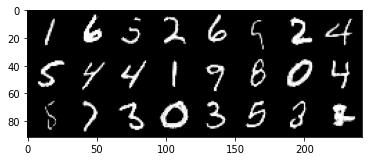

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.48it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 156, lossD: 0.22176137488799047, lossG: 6.151328104121218


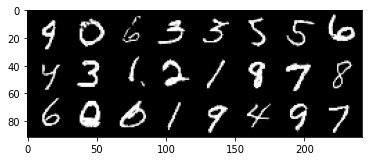

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 157, lossD: 0.0889053627315448, lossG: 6.052457577129926


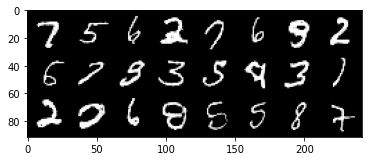

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.31it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 158, lossD: 0.1522557213654253, lossG: 6.268136742637991


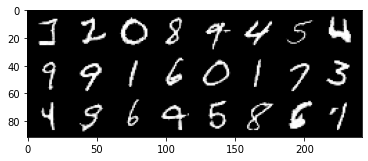

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 30.18it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 159, lossD: 0.10572616133450675, lossG: 6.237380646375705


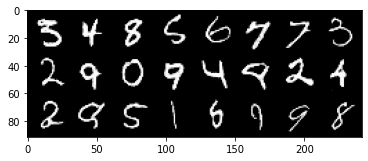

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:31<00:00, 30.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 160, lossD: 0.16348518726692945, lossG: 6.289222587368636


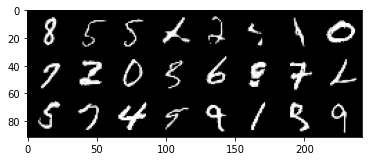

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.54it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 161, lossD: 0.12801826233044267, lossG: 6.133349999499473


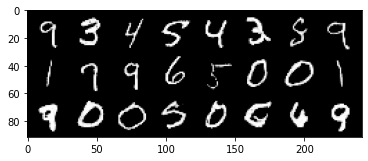

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 162, lossD: 0.11358688490937895, lossG: 6.236254929352417


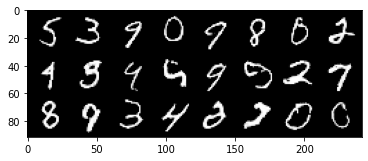

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.64it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 163, lossD: 0.15448058160346573, lossG: 6.346220667237666


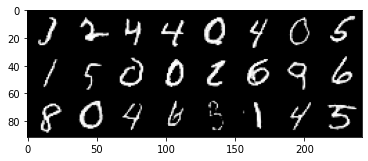

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.28it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 164, lossD: 0.1090208325492365, lossG: 6.1734437017616175


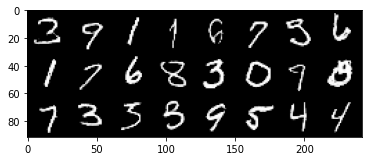

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 165, lossD: 0.12779927123792229, lossG: 6.62751009650449


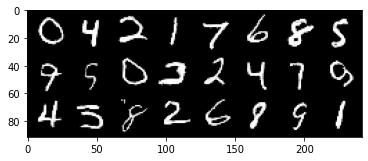

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.58it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 166, lossD: 0.1265673701311829, lossG: 6.238382380225384


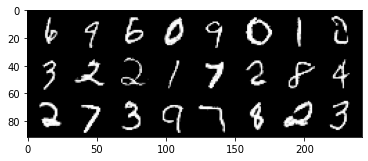

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 167, lossD: 0.07591671709255227, lossG: 6.333202938789498


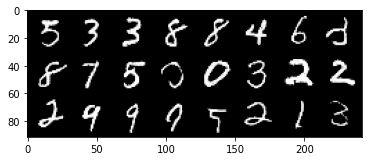

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.42it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 168, lossD: 0.14985264518257502, lossG: 6.305796973856051


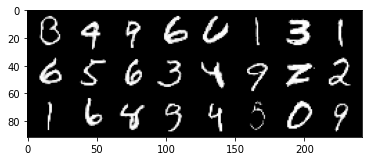

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.47it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 169, lossD: 0.16392930413532789, lossG: 6.121986729622102


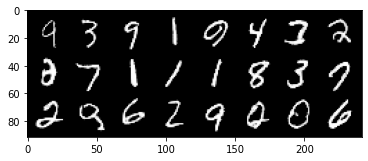

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.63it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 170, lossD: 0.20205355212745219, lossG: 6.227561113718492


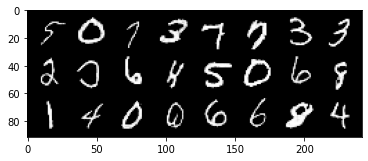

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.58it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 171, lossD: 0.09647383272344036, lossG: 6.222773237936278


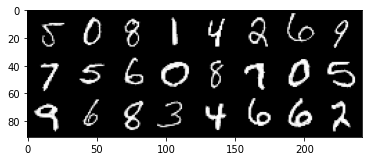

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.41it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 172, lossD: 0.13957821501484477, lossG: 6.344335772319516


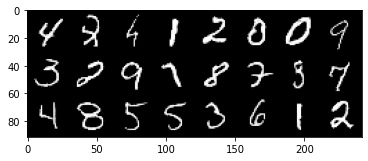

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 173, lossD: 0.08453821330363534, lossG: 6.458985938509898


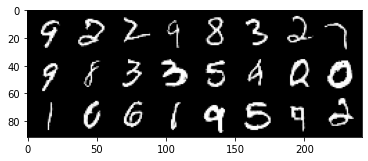

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.48it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 174, lossD: 0.13871579593234162, lossG: 6.4988133518585265


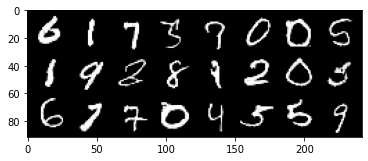

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.40it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 175, lossD: 0.07438098629718141, lossG: 6.457063330770302


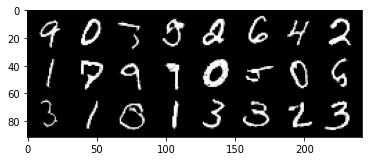

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.44it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 176, lossD: 0.187948121273491, lossG: 6.343739555160359


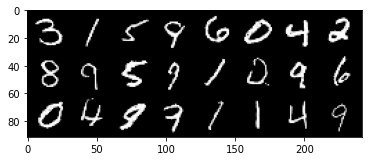

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.49it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 177, lossD: 0.03924953099191268, lossG: 6.739761984932906


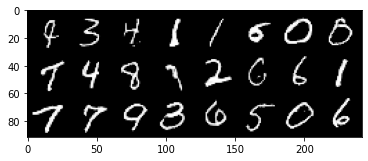

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.64it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 178, lossD: 0.23161985301551646, lossG: 6.0684404117879325


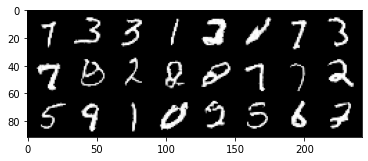

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 179, lossD: 0.053752027058066414, lossG: 6.445181752572944


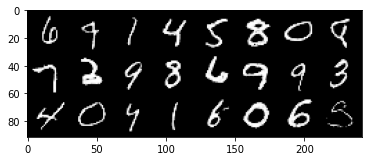

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.35it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 180, lossD: 0.1793101714918517, lossG: 6.383926746171357


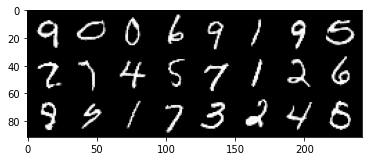

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.40it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 181, lossD: 0.051687439196437264, lossG: 6.62739255204638


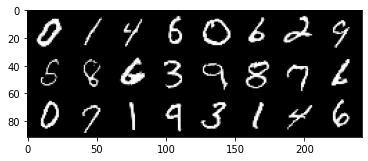

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 182, lossD: 0.2061735871698467, lossG: 6.297283829956341


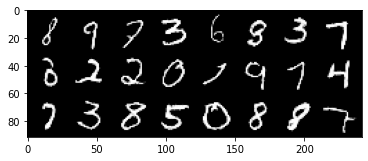

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 183, lossD: 0.03536189741344312, lossG: 6.756006921532312


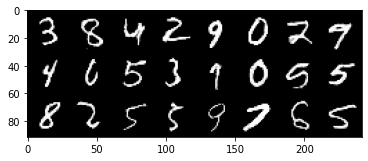

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 184, lossD: 0.16964684729712573, lossG: 6.495188607343796


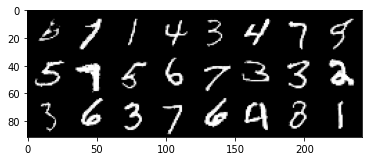

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.40it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 185, lossD: 0.03644282394560423, lossG: 6.824882484194058


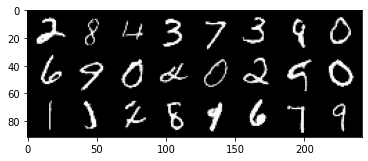

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 186, lossD: 0.19703114715189848, lossG: 6.3607529801155716


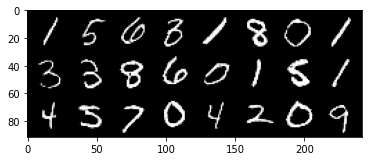

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 187, lossD: 0.12423740566866015, lossG: 6.478870445540719


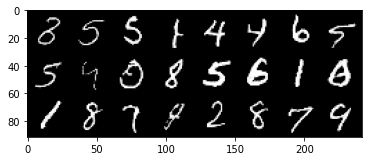

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.36it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 188, lossD: 0.10264611123219085, lossG: 6.809501922333927


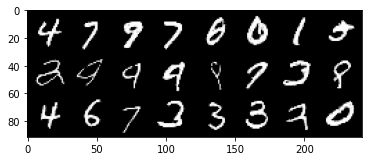

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.28it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 189, lossD: 0.10462049320280584, lossG: 6.342561179386782


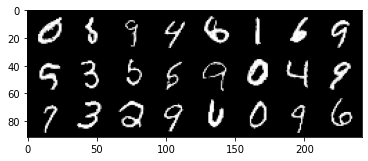

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.53it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 190, lossD: 0.1276657337055746, lossG: 6.357714501207571


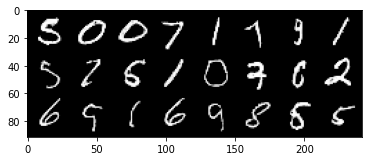

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.53it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 191, lossD: 0.09127621161778754, lossG: 6.780323274957854


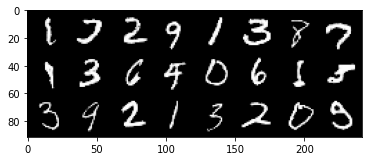

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.61it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 192, lossD: 0.09924186575588888, lossG: 6.61314860589977


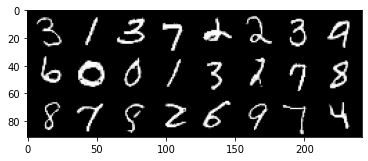

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.68it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 193, lossD: 0.1394994128792078, lossG: 6.334906373848158


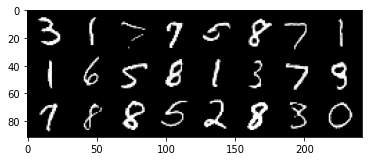

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 194, lossD: 0.11255338924293067, lossG: 6.994649914726774


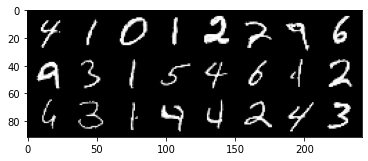

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.46it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 195, lossD: 0.07183745339699486, lossG: 6.550977479992136


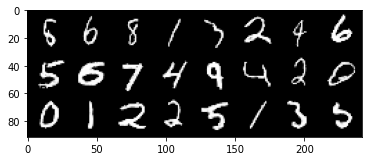

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.52it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 196, lossD: 0.15943447762041854, lossG: 6.311944092204894


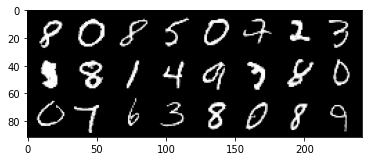

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.72it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 197, lossD: 0.11295629721129936, lossG: 6.78742862850237


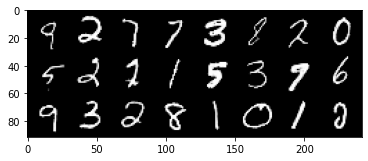

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.54it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 198, lossD: 0.06627987840695422, lossG: 6.672506208612975


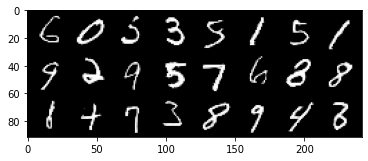

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 199, lossD: 0.21157487957422605, lossG: 6.576598540631566


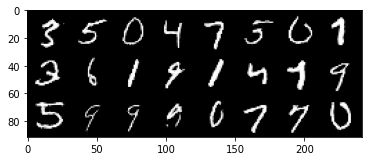

100%|█████████████████████████████████████████████████████████████████████████████████| 938/938 [00:30<00:00, 30.62it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch: 200, lossD: 0.03301922410854629, lossG: 6.820222545788487


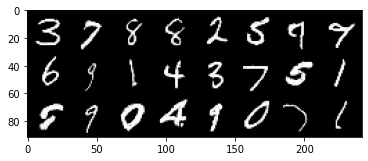

In [9]:
#損失関数を格納するリストを作成
lossesD=[]
lossesG=[]

#イテレーションごとの損失関数を格納するリストを作成
raw_lossesD=[]
raw_lossesG=[]

#エポックごとのループ処理
for epoch in range(opt.n_epoch):
    #損失関数の値の初期化
    running_lossD=0.0
    running_lossG=0.0
    #ミニバッチごとのループ処理
    for i,(real_imgs,labels) in enumerate(tqdm.tqdm(dataloader,position=0)):
        #画像をデバイスに送る
        real_imgs=real_imgs.to(device)
        
        #バッチサイズ指定(最後のループでは指定した以外のサイズになるので、このように指定している)
        batch_size=real_imgs.size()[0]
        
        #生成器に与えるノイズを定義
        noise=torch.randn(batch_size,opt.z_dim,1,1).to(device)
        
        #labelの値を定義する　本物の画像:1 偽の画像:0
        shape=(batch_size,1,1,1)
        label_real=torch.ones(shape).to(device)
        label_fake=torch.zeros(shape).to(device)
        
        #####################
        #####識別器の学習#####
        #####################
        
        #勾配の初期化
        netD.zero_grad()
        
        #本物の画像の識別を行わせ、損失関数の値を取得する
        output=netD(real_imgs)
        lossD_real=criterion(output,label_real)
        
        #偽の画像を生成器で作成し、これを識別器に識別を行わせ、損失関数の値を取得する
        fake_imgs=netG(noise)
        output=netD(fake_imgs.detach())
        lossD_fake=criterion(output,label_fake)
        
        #トータルの損失関数を取得
        lossD=lossD_real+lossD_fake
        
        #トータルの損失関数を元にバックワードさせ、optimizerを使い1ステップ最適化させる
        lossD.backward()
        optimizerD.step()
        
        #####################
        #####生成器の学習#####
        #####################
        
        #勾配の初期化
        netG.zero_grad()
        
        #偽の画像(fake_imgs)を識別器に渡し、本物と判定させたいので損失関数に本物の画像のラベルを渡す
        output=netD(fake_imgs)
        lossG=criterion(output,label_real)
        
        #損失関数を元にバックワードさせ、optimizerを使い1ステップ最適化させる
        lossG.backward()
        optimizerG.step()
        
        #####################
        ######損失の保存######
        #####################
        
        #ミニバッチごとの損失を足していき、エポックごとの合計損失を計算
        running_lossD+=lossD.item()
        running_lossG+=lossG.item()
        
        #ミニバッチごとの損失を保存
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())
        
    #エポックごとの合計損失を平均化して保存
    running_lossD/=len(dataloader)
    running_lossG/=len(dataloader)
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)
    
    
    print("epoch: {}, lossD: {}, lossG: {}".format(epoch+1,running_lossD,running_lossG))
    
    #####################
    #####偽の画像表示#####
    #####################
    
    #24枚分を合わせて表示するように指定
    grid_imgs=vutils.make_grid(fake_imgs[:24].detach())
    grid_imgs_arr=grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr,(1,2,0)))
    plt.show()
    
    ########################
    #偽の画像とパラメータ保存#
    ########################
    
    #全て出力すると邪魔なので、10回毎と学習の最後のみに出力
    if (epoch)%10==0:
        vutils.save_image(fake_imgs,"./result/epoch_{}.jpg".format(epoch))
        save_params("./params/",epoch,netD,netG)
    elif epoch==(opt.n_epoch-1):
        vutils.save_image(fake_imgs,"./result/epoch_last.jpg")
        torch.save(netG.state_dict(),"./params/g_last.pth")
        torch.save(netD.state_dict(),"./params/d_last.pth")

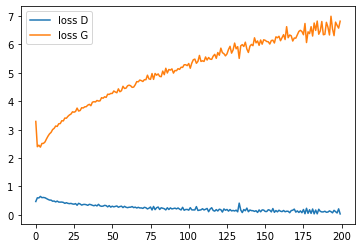

In [10]:
plt.plot(lossesD,label="loss D")
plt.plot(lossesG,label="loss G")
plt.legend()
plt.savefig("./result/loss_history.jpg")
plt.show()